In [1]:
import glob
from timeit import default_timer as timer

import numpy as np
import torch
import clip
import hydra
import omegaconf
from PIL import Image
from torch import nn
import torchvision.transforms as T
import scipy.special

import pandas as pd
from tqdm import tqdm
import os
from pathlib import Path

In [2]:
def convert_image_to_rgb(image):
    return image.convert("RGB")


def _transform(
        n_px=224,
        norm_mean=(0.48145466, 0.4578275, 0.40821073),
        norm_std=(0.26862954, 0.26130258, 0.27577711)):
    return T.Compose([
        T.RandomResizedCrop(
            size=n_px,
            scale=(0.7, 1.0),
            ratio=(0.75, 1.33),
            interpolation=T.InterpolationMode.BICUBIC,
        ),
        T.RandomVerticalFlip(p=0.5),
        T.RandomHorizontalFlip(p=0.3),
        convert_image_to_rgb,
        T.RandomApply(
            nn.ModuleList(
                [
                    T.ColorJitter(
                        brightness=0.2,
                        contrast=0.2,
                        saturation=0.1,
                        hue=0.0,
                    )
                ]
            ),
            p=1.0,
        ),
        T.ToTensor(),
        T.Normalize(norm_mean, norm_std),
    ])

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# CONSTANTS
MODEL = "ViT-L-14"
DATASET = "derm7pt"
ADDITIONAL_COMMENTS = "CLASS_LABELS_PROMPTS"

In [6]:
# 1. Load Model
model_name = "zt0n2xd0"

print("[INFO] Loading model...")
cfg_model = omegaconf.OmegaConf.load("../configs/model/contrastive.yaml")
cfg_model.net.model_name_or_path = "ViT-L/14"
cfg_model.net.device = device

model = hydra.utils.instantiate(cfg_model)
model.to(device)
model.eval()

model_path_dir = {
    "zt0n2xd0": "/home/cristianopatricio/Downloads/weight.pt",
}

# Load model with saving weights
model_path = model_path_dir[model_name]
loaded = torch.load(model_path, map_location=device)
model.load_state_dict(loaded)
print('[INFO] Model loaded successfully!')

[INFO] Loading model...
[INFO] Model loaded successfully!


In [5]:
CLASS_LABELS_PROMPTS = {
    "Melanoma": ["This is dermatoscopy of melanoma"],
    "Nevus": ["This is dermatoscopy of nevus"]
}

In [8]:
# Extract text features for each concept and save it to a numpy array
for disease_label in CLASS_LABELS_PROMPTS.keys():
    preprocess = _transform()
    batch = {
        "text": clip.tokenize(CLASS_LABELS_PROMPTS[disease_label]).to(device)
    }

    with torch.no_grad():
        text_features = model.model_step_with_text(batch)["text_features"]
    
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    np.save(f"text_embeddings/class_label_embeddings_{disease_label}.npy", text_features.detach().cpu().numpy())
print("[INFO] Completed!")

[INFO] Completed!


In [6]:
from scipy.special import softmax

def get_similarity_score(image_features, text_features):
    similarity = np.dot(image_features, text_features.T)

    return similarity

In [7]:
def calculate_similarity_score(image_features_norm,
                               prompt_target_embedding_norm,
                               prompt_ref_embedding_norm,
                               temp=1,
                               top_k=-1,
                               normalize=True):

    #rint(image_features_norm.shape)
    #print(prompt_target_embedding_norm.shape)
    #print(prompt_ref_embedding_norm.shape)

    target_similarity = prompt_target_embedding_norm.float() @ image_features_norm.T.float()
    ref_similarity = prompt_ref_embedding_norm.float() @ image_features_norm.T.float()


    if top_k > 0:
        idx_target = target_similarity.argsort(dim=1, descending=True)
        target_similarity_mean = target_similarity[:,idx_target.squeeze()[:top_k]].mean(dim=1)
        
        ref_similarity_mean = ref_similarity.mean(dim=1)
    else:
        target_similarity_mean = target_similarity.mean(dim=1)
        ref_similarity_mean = ref_similarity.mean(dim=1)
    
    if normalize:
        similarity_score = scipy.special.softmax([target_similarity_mean.numpy(), ref_similarity_mean.numpy()], axis=0)[0, :].mean(axis=0)
    else:
        similarity_score = target_similarity_mean.mean(axis=0)

    return similarity_score

In [15]:
# Get image embeddings 
print(f"[INFO] DATASET: {DATASET}")
img_embeddings = np.load(f"img_embeddings/image_embeddings_{DATASET}_MONET_{MODEL}_Segmented_Norm.npy", allow_pickle=True).item()
reference_embeddings = torch.from_numpy(np.load(f"concept_embeddings/reference_concept_embeddings.npy")).unsqueeze(0)

results = dict()
# Iterate over images and calculate similarity
for im in img_embeddings.keys():
    img_feats = torch.from_numpy(img_embeddings[im]).unsqueeze(0)
    #print(f"IMG shape: {img_feats.shape}")

    similarity_scores = []
    for disease_label in CLASS_LABELS_PROMPTS.keys():
        text_feats = torch.from_numpy(np.load(f"text_embeddings/class_label_embeddings_{disease_label}.npy")).unsqueeze(0)
        # For FT
        #text_feats = torch.from_numpy(np.load(f"text_embeddings/class_label_embeddings_{disease_label}_MONET_{MODEL}.npy")).unsqueeze(0)
        #print(f"TEXT shape: {text_feats.shape}")

        #similarity = get_similarity_score(img_feats, text_feats)
        similarity = calculate_similarity_score(image_features_norm=img_feats,
                                                prompt_target_embedding_norm=text_feats,
                                                prompt_ref_embedding_norm=reference_embeddings,
                                                top_k=-1,
                                                temp=(1/np.exp(4.5944)),
                                                normalize=True)

        similarity_scores.append(similarity[0])

    # Calculate prediction given weights of melanoma
    results[im] = similarity_scores

[INFO] DATASET: derm7pt


In [16]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, balanced_accuracy_score, auc

if DATASET == "PH2":
    gt = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/PH2Dataset/PH2_dataset.csv")
    
    train_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/PH2_train.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/PH2_validation.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/PH2_test.csv")
    test_images = test_images_df["images"].tolist()

elif DATASET == "derm7pt":
    gt = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/Derm7pt/image_classes_derm7pt.csv")
    
    train_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/derm7pt_train_seg.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/derm7pt_validation_seg.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/derm7pt_test_seg.csv")
    test_images = test_images_df["images"].tolist()


y_true_val = []
y_pred_probs_val = []
for im in results.keys():

    if str(im) in validation_images:
        y_true_val.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred_probs_val.append(np.max(results[im]))

fpr, tpr, thresholds = roc_curve(y_true_val, y_pred_probs_val)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

y_true = []
y_pred = []
y_pred_probs = []
for im in results.keys():
    
    if str(im) in test_images:
        y_true.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred.append(1 if np.max(results[im]) > optimal_threshold else 0)
        y_pred_probs.append(np.max(results[im]))

print(classification_report(y_true=y_true, y_pred=y_pred, target_names=["MEL", "NEV"]))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
print(conf_matrix)

# Calculate AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# BACC
bacc = balanced_accuracy_score(y_true, y_pred)
print(f"BACC: {bacc}")

# Sensitivity
SE = TP / (TP + FN)
print(f"Sensitivity: {SE}")

# Specificity
SP = TN / (TN + FP)
print(f"Specificity: {SP}")

Threshold value is: 0.50525546
              precision    recall  f1-score   support

         MEL       0.72      0.84      0.78       219
         NEV       0.46      0.29      0.35       101

    accuracy                           0.67       320
   macro avg       0.59      0.57      0.57       320
weighted avg       0.64      0.67      0.64       320

[[185  34]
 [ 72  29]]
AUC: 0.6340702563407026
BACC: 0.5659387856593878
Sensitivity: 0.2871287128712871
Specificity: 0.8447488584474886


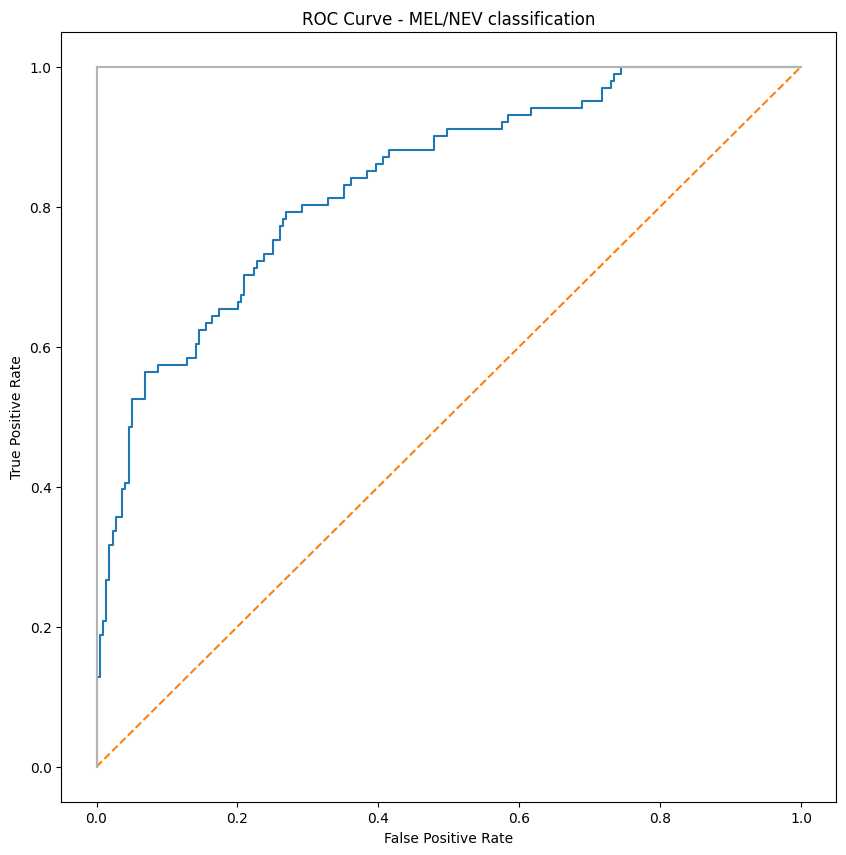

In [43]:
# Plot ROC AUC curve
import matplotlib.pyplot as plt

plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve - MEL/NEV classification')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()